# Анализ тональности отзывов. Неделя 6:
## Peer-graded Assignment: Разработка сентимент-анализа под задачу заказчика

К вашей компании пришел заказчик, которому нужно решение задачи анализа тональности отзывов на товары. Заказчик хочет, чтобы вы оценили возможное качество работы такого алгоритма на небольшой тестовой выборке. При этом больше никаких данных вам не предоставляется. Требуется, чтобы качество работы вашего алгоритма (по accuracy) было строго больше 85%.

Оценка качества в этом задании реализована через контест на Kaggle Inclass:
https://inclass.kaggle.com/c/product-reviews-sentiment-analysis

Вам предстоит посмотреть на предоставленные заказчиком отзывы, собрать похожие отзывы в качестве обучающей выборки, и поэкспериментировать с постановкой задачи (разметкой вашей выборки на позитивные и негативные примеры) так, чтобы результат на примерах заказчика был по возможности получше.

Обратите внимание, что заказчик предоставил всего 100 примеров в качестве тестовой выборки - ситуация, когда размеченных данных почти нет - вообще очень частая в индустриальном анализе данных. Конечно, эти отзывы можно было бы идеально разметить вручную и получить максимальное качество, но вы сами не заинтересованы в таком подходе, т.к. потом придется и на всех новых примерах демонстрировать заказчику идеальную работу, что, конечно, вряд ли будет по силам алгоритму. В любом случае рано или поздно алгоритм придется разрабатывать, поэтому попытки "сжульничать" и не делать никакой модели не одобряются.

In [182]:
import pandas as pd
import numpy as np
import requests
import bs4
import codecs
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from nltk.corpus import stopwords
from sklearn.externals import joblib

In [3]:
# загрузим тестовую выборку от заказчика:
# тестовая выборка в формате <review>текст_отзыва_1</review> два перевода строки <review>текст_отзыва_2</review> и т.д.
with codecs.open('test.csv', 'rb', encoding='utf8') as f: # придется применить кодирование в utf8
    data = f.read()

test = [review.text for review in bs4.BeautifulSoup(data, 'lxml').find_all('review')]

In [4]:
print('всего в тестовом наборе {} отзывов \n\nВот первый из них: \n{}'.format(len(test), test[0]))

всего в тестовом наборе 100 отзывов 

Вот первый из них: 
Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти.
Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться.



### Парсинг

Прочтя неколько отзывов, можно убедится что речь идет о мобильных телефонах. Следовательно нам нужно парсить сайт об отзывах именно мобильных телефонов: https://torg.mail.ru/review/goods/mobilephones/

Создадим функцию парсинга данного сайта (аргументы: базовая страница сайта, количество страниц для парсинга)

In [119]:
def Parser(Site='https://torg.mail.ru/review/goods/mobilephones/?page=', n=10):
    
    Comment = [] # список комментариев
    Rating = [] # список оценок
    
    for i in range(1,n+1):

        site = Site + str(i) # ссылка на i-ую страницу сайта

        req = requests.get(site)
        parser = bs4.BeautifulSoup(req.text, 'lxml') # парсинг страницы site

        # Опытным путем выявлено:
        # <div class="review-item__content"> - блок содержащий отзыв о телефоне (правда там мусора много, потом думаю избавиться)
        # <span class="review-item__rating-counter">4</span> - блок с оценкой отзыва (он выше самго отзыва)

        comment = parser.findAll('div', attrs={'class':'review-item__content'})
        rating = parser.findAll('span', attrs={'class':'review-item__rating-counter'})

        # добавляем в списки новые комменты и их оценки
        Comment.extend(list(map(lambda x: x.text, comment)))
        Rating.extend(list(map(lambda x: float(x.text.replace(',','.')), rating)))
        
    return Comment, Rating

Новая функция грамотного разделения отзывов. Делим отзыв на три:
1. сам отзыв и соответствующая оценка для него
2. достоинства с положительной оценкой
3. недостатки с отрицательной оценкой

In [125]:
def Parser_2(Site='https://torg.mail.ru/review/goods/mobilephones/?page=', n=10):
    
    Comment = [] # список комментариев
    Rating = [] # список оценок
    
    for i in range(1,n+1):

        site = Site + str(i) # ссылка на i-ую страницу сайта

        req = requests.get(site)
        parser = bs4.BeautifulSoup(req.text, 'lxml') # парсинг страницы site

        comment = parser.findAll('div', attrs={'class':'review-item__content'})
        rating = parser.findAll('span', attrs={'class':'review-item__rating-counter'})


        # выяснено опытным путем, что p[0]-отзыв, p[1]-достоинства, p[2]-недостатки
        for c,r in zip(comment,rating):
            p = c.findAll('p', attrs={'class':'review-item__paragraph'}) # параграфы нулевого отзыва
            
            # рассматриваем только полные отзывы (с комментом, достоинствами и недостатками)
            if len(p)==3:
                Comment.extend(list(map(lambda x: x.text, p))) # p[0]-отзыв, p[1]-достоинства, p[2]-недостатки
                rat = []
                if float(r.text.replace(',','.'))>=4: rat.append(1)
                else: rat.append(0)
                rat.append(1) # добавляем достоинство p[1]
                rat.append(0) # добавляем недостаток p[2]
                Rating.extend(rat)
    
    return Comment, Rating

Произведем парсинг по 100 страницам и сформируем выборки:

In [130]:
%%time
X, y = Parser_2(n=500)

Wall time: 16min 54s


In [128]:
# можно посмотреть на достоинства и недостатки
# for r,c in zip(y[:30],X[:30]):
#     print(r,':',c,'\n')

Составление датафрейма по данным с парсинга:

In [131]:
# Составим датафрейм по нашим собраным отзывам
train_df = pd.DataFrame({'Comment': X, 'Rating':y})

# Составим датафрейм по тестовым отзывам заказчика
test_df = pd.DataFrame({'Comment':test})

In [142]:
# X = None # освобожу память
# y = None

In [143]:
print('размер обучающей выборки: {}'.format(train_df.shape))

размер обучающей выборки: (25239, 2)


In [144]:
train_df.head(3)

,Comment,Rating
0,\nв корне не согласен с прежним отзывом. телеф...,1
1,"\nсд карта, не убиваемый телефон - разбился на...",1
2,"\nвход на наушники не стандартный, нужно привы...",0


In [145]:
test_df.head(3)

,Comment
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментариях\nК сожалению, факт по..."


Сохраним полученные данные (необработанные от мусора)

In [166]:
train_df.to_csv('data_Not_Treated.csv', index=False)

In [ ]:
# Раскоментировать при подгрузке файла
# train_df = pd.read_csv('data_Not_Treated.csv', encoding='cp1251')
# train_df.head()

### Предобработка данных

In [146]:
wnl = WordNetLemmatizer() # лемматизация
A = []; B = []

for Tweet in train_df['Comment']:
    Tweet = re.sub(r'[^\w\s]+|[\d]+', r'', Tweet).strip()
    Tokens = nltk.word_tokenize(Tweet)
    Stemmed = [wnl.lemmatize(token).lower() for token in Tokens]
    A.append(Stemmed)


for Tweet in test_df['Comment']:
    Tweet = re.sub(r'[^\w\s]+|[\d]+', r'', Tweet).strip()
    Tokens = nltk.word_tokenize(Tweet)
    Stemmed = [wnl.lemmatize(token).lower() for token in Tokens]
    B.append(Stemmed)
    
    
# преобразование (склейка) в список строк
X_train = list(map(lambda x: ' '.join(x), A))
X_test = list(map(lambda x: ' '.join(x), B))

Если парсинг по первому алгоритму то: В нашей модели признаки являются количественными, перейдем к бинарным (0-отзыв негативный, 1-отзыв положительный)

In [150]:
# y_train = train_df['Rating'].apply(lambda x: 1 if x>=4 else 0)
y_train = train_df['Rating']

In [151]:
# train_df = None # освобожу память
# test_df = None

Сохраним уже обработанные данные

In [ ]:
pd.DateFrame({'Comment': X_train, 'Rating': y_train}).to_csv('data_Processed.csv', index=False)

### Обучение и выбор модели

In [152]:
y_train.value_counts()

1    15078
0    10161
Name: Rating, dtype: int64

Если парсинг по первому алгоритму то выборка будет несбалансирована, учтём это

In [155]:
%%time
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2))
Model = LogisticRegression(class_weight='balanced', random_state=17)
pipeline = Pipeline([("vect", vectorizer), ("model", Model)])

score = cross_val_score(pipeline, X_train, y_train, cv=5)

Wall time: 25 s


In [159]:
print(score.mean())

0.8520541672330901


Оптимизация праметров

In [160]:
%%time
vectorizer = TfidfVectorizer()
Model = LogisticRegression(class_weight='balanced', random_state=17)
pipeline = Pipeline([("vect", vectorizer), ("model", Model)])

param_grid = {'vect__ngram_range': [(1,1), (1,2), (1,3)],
              'vect__min_df': [1,2,3,4,5],
              'model__C': [0.0001,0.001,0.01,0.1,1,10,100,1000]
             }


grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)

Wall time: 1h 12min 1s


In [171]:
print("Наилучшее значение перекр проверки: {:.3f}".format(grid.best_score_))
print("Наилучшие параметры: {}".format(grid.best_params_))

Наилучшее значение перекр проверки: 0.854
Наилучшие параметры: {'model__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}


### Лучшая модель показала на тестовой выборке 98%

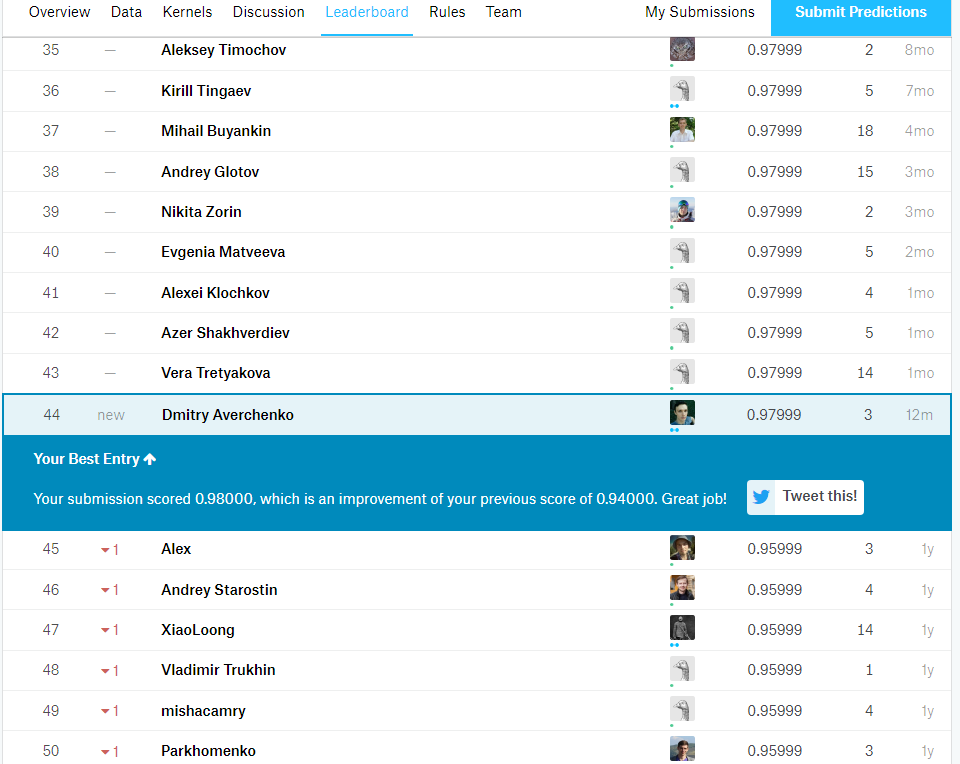

In [191]:
from PIL import Image
image = Image.open("1.png") # Открываем изображение
image

Запишем данную лучшую модель в pkl. По данной модели будем строить прогнозы в flask

In [192]:
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 2))
Model = LogisticRegression(C=10, class_weight='balanced', random_state=17)

X_transform = vectorizer.fit_transform(X_train)
Model.fit(X_transform, y_train)

joblib.dump(vectorizer, "Model_CountVectorizer.pkl")
joblib.dump(Model, "Model_LogisticRegressionClassifier.pkl")

['Model_LogisticRegressionClassifier.pkl']